# ITU 5G Energy Consumption Challenge - GitData

<font color="red">Please make a copy of this Jupyter Notebook to your own Google Drive or local machine before changing anything.</font>

This Jupyter Notebook will also be updated regularly on GitHub: https://github.com/GitData-GA/itu5g/tree/main/code/ITU_5G_Energy_Consumption_Challenge.ipynb

In [1]:
# Import all libraries here
import random
random.seed(88)
import pandas as pd
import numpy as np
np.random.seed(88)
import tensorflow as tf
tf.random.set_seed(88)
from tensorflow import keras
keras.utils.set_random_seed(88)
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt

## Data Preparation

In [2]:
# Output format
# Description: The file contains days, hours, and base stations for which we
# need energy consumption estimation and will be used for scoring predictions.
power_pred = pd.read_csv('https://data.gd.edu.kg/bwz7t527/power_consumption_prediction.csv')
# Dataset 1
# Description: Energy consumption data (ECdata.csv): include hour-level energy
# consumption specifications (e.g., total energy consumption of the base stations).
ECdata = pd.read_csv('https://data.gd.edu.kg/bwz7t527/ECdata.csv')
# Dataset 2
# Description: Cell-level data (CLdata.csv): include hour-level counters,
# including service compliance counters (e.g., load) and energy-saving methods
# counters (e.g., duration of energy saving mode activation).
CLdata = pd.read_csv('https://data.gd.edu.kg/bwz7t527/CLdata.csv')
# Dataset 3
# Description: Base Station basic information (BSinfo.csv): include
# configuration parameters and hardware attributes
BSinfo = pd.read_csv('https://data.gd.edu.kg/bwz7t527/BSinfo.csv')

In [3]:
# Merge data
data = CLdata.merge(BSinfo, on=["BS", "CellName"], how="left").merge(ECdata, on=["Time", "BS"], how="left")
data['Time'] = pd.to_datetime(data['Time'])
data_copy = data.copy()  # Use .copy() to avoid SettingWithCopyWarning

# Split Year, Month, Day, and Hour
data.sort_values(by='Time', inplace=True)
data['Year'] = data['Time'].dt.year
data['Month'] = data['Time'].dt.month
data['Day'] = data['Time'].dt.day
data['Hour'] = data['Time'].dt.hour

# Change column position
data = data[['Year', 'Month', 'Day', 'Hour'] + [col for col in data.columns if col not in ['Year', 'Month', 'Day', 'Hour']]]

In [4]:
temp_data = data.dropna().reset_index(drop=True)
total_load = temp_data.groupby(['Time', 'BS'])['load'].sum().reset_index()
multiple_cellnames = total_load[total_load.duplicated(['Time', 'BS'], keep=False)]
multiple_cellnames['Proportion'] = multiple_cellnames.groupby(['Time', 'BS'])['load'].transform(lambda x: x / x.sum())
temp_data.loc[data['BS'].isin(multiple_cellnames['BS']), 'Energy'] *= multiple_cellnames['Proportion']
y = temp_data['Energy']

In [5]:
# One-hot encode categorical features
categorical_cols = ['BS', 'CellName', 'RUType', 'Mode']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Training data
train_data = data.dropna().reset_index(drop=True)

# Extract target variable 'Energy' and 'Time'
time_train = train_data['Time']
train_data = train_data.drop(columns=['Energy', 'Time'])

# Standardize numerical features
scaler = StandardScaler()
train_data[train_data.columns] = scaler.fit_transform(train_data[train_data.columns])

# Data need to predict
unknown_data = data[data.isna().any(axis=1)].reset_index(drop=True)
time_unknown = unknown_data['Time']
unknown_data = unknown_data.drop(columns=['Energy', 'Time'])

# Standardize numerical features
unknown_data[unknown_data.columns] = scaler.transform(unknown_data[unknown_data.columns])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(train_data, y, test_size=0.2, shuffle=False)

# Convert data to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Time series transformation
X_train_ts = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_ts = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Model Training

In [6]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

callbacks = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "best.model",
    save_best_only=True,
    monitor='val_loss'
)

In [ ]:
# LSTM Model - Time series
lstm_model = keras.Sequential([
    layers.LSTM(units=128, recurrent_dropout=0.1225),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
lstm_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss="mean_absolute_percentage_error")


# Train the model
history = lstm_model.fit(X_train_ts, y_train, epochs=50, batch_size=32,
                         validation_split=0.2,
                         callbacks = [callbacks, model_checkpoint])

# Fit model on validation set and get error
y_pred = lstm_model.predict(X_test_ts)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_lstm:.5f}%')

lstm_model.summary()

Epoch 1/50
1962/1962 [==============================] - 41s 14ms/step - loss: 30.1086 - val_loss: 9.9849
Epoch 2/50
1962/1962 [==============================] - 28s 14ms/step - loss: 15.1249 - val_loss: 8.2180
Epoch 3/50
1962/1962 [==============================] - 28s 14ms/step - loss: 13.3314 - val_loss: 7.8021
Epoch 4/50
1962/1962 [==============================] - 27s 14ms/step - loss: 12.3656 - val_loss: 7.5544
Epoch 5/50
1962/1962 [==============================] - 45s 23ms/step - loss: 11.5431 - val_loss: 7.4178
Epoch 6/50
1962/1962 [==============================] - 36s 18ms/step - loss: 10.8722 - val_loss: 6.6672
Epoch 7/50
1962/1962 [==============================] - 42s 21ms/step - loss: 10.4237 - val_loss: 6.6003
Epoch 8/50
1962/1962 [==============================] - 35s 18ms/step - loss: 9.9899 - val_loss: 6.3908
Epoch 9/50
1962/1962 [==============================] - 32s 16ms/step - loss: 9.6418 - val_loss: 6.5164
Epoch 10/50
1962/1962 [==============================] - 

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

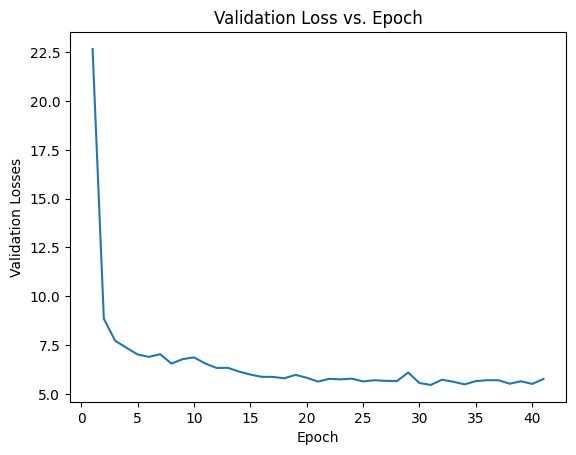

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [ ]:
# GRU Model - Time series
gru_model = keras.Sequential([
    layers.GRU(units=128, recurrent_dropout=0.1225),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
gru_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss="mean_absolute_percentage_error")


# Train the model
history = gru_model.fit(X_train_ts, y_train, epochs=50, batch_size=32,
                         validation_split=0.2,
                         callbacks = [callbacks, model_checkpoint])

# Fit model on validation set and get error
y_pred = gru_model.predict(X_test_ts)
mape_gru = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_gru:.5f}%')

gru_model.summary()

Epoch 1/50
62/62 [==============================] - 7s 22ms/step - loss: 96.2590 - mean_absolute_percentage_error: 96.2590 - val_loss: 91.3157 - val_mean_absolute_percentage_error: 91.3157
Epoch 2/50
62/62 [==============================] - 1s 15ms/step - loss: 72.7557 - mean_absolute_percentage_error: 72.7557 - val_loss: 53.9261 - val_mean_absolute_percentage_error: 53.9261
Epoch 3/50
62/62 [==============================] - 1s 15ms/step - loss: 53.3610 - mean_absolute_percentage_error: 53.3610 - val_loss: 46.6235 - val_mean_absolute_percentage_error: 46.6235
Epoch 4/50
62/62 [==============================] - 1s 14ms/step - loss: 49.8965 - mean_absolute_percentage_error: 49.8965 - val_loss: 43.4564 - val_mean_absolute_percentage_error: 43.4564
Epoch 5/50
62/62 [==============================] - 1s 13ms/step - loss: 47.0290 - mean_absolute_percentage_error: 47.0290 - val_loss: 40.0047 - val_mean_absolute_percentage_error: 40.0047
Epoch 6/50
62/62 [==============================] - 1s 

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

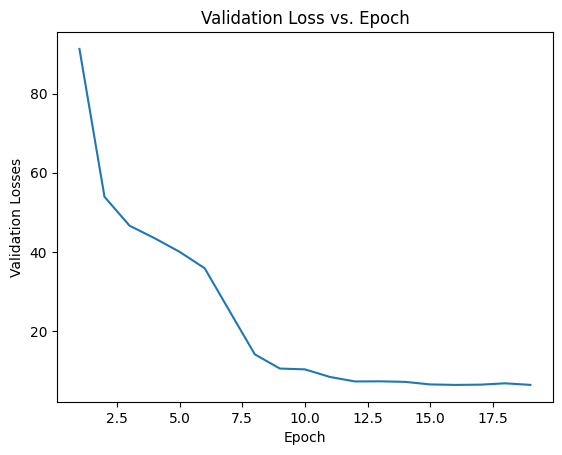

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [ ]:
# RNN Model - Time series
rnn_model = keras.Sequential([
    layers.SimpleRNN(units=128, recurrent_dropout=0.12),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
rnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss="mean_absolute_percentage_error")


# Train the model
history = rnn_model.fit(X_train_ts, y_train, epochs=50, batch_size=32,
                         validation_split=0.2,
                         callbacks = [callbacks, model_checkpoint])

# Fit model on validation set and get error
y_pred = rnn_model.predict(X_test_ts)
mape_rnn = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_rnn:.5f}%')

rnn_model.summary()

Epoch 1/50
1962/1962 [==============================] - 22s 9ms/step - loss: 28.1989 - mean_absolute_percentage_error: 28.1989 - val_loss: 9.5667 - val_mean_absolute_percentage_error: 9.5667
Epoch 2/50
1962/1962 [==============================] - 17s 9ms/step - loss: 15.3661 - mean_absolute_percentage_error: 15.3661 - val_loss: 8.7655 - val_mean_absolute_percentage_error: 8.7655
Epoch 3/50
1962/1962 [==============================] - 16s 8ms/step - loss: 13.4017 - mean_absolute_percentage_error: 13.4017 - val_loss: 8.2042 - val_mean_absolute_percentage_error: 8.2042
Epoch 4/50
1962/1962 [==============================] - 16s 8ms/step - loss: 12.3320 - mean_absolute_percentage_error: 12.3320 - val_loss: 8.0042 - val_mean_absolute_percentage_error: 8.0042
Epoch 5/50
1962/1962 [==============================] - 16s 8ms/step - loss: 11.6142 - mean_absolute_percentage_error: 11.6142 - val_loss: 7.8814 - val_mean_absolute_percentage_error: 7.8814
Epoch 6/50
1962/1962 [=======================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

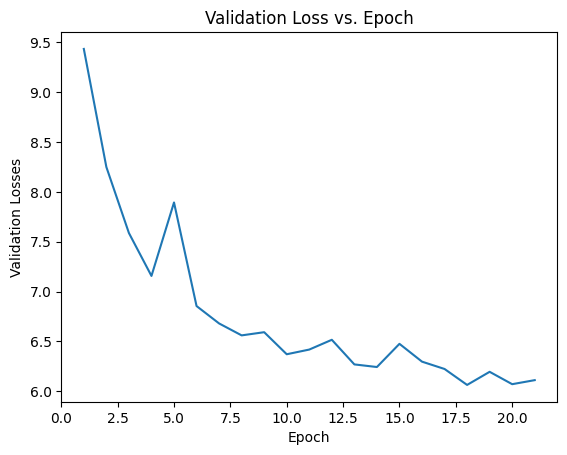

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [ ]:
# Regression Model - Regression
reg_model = keras.Sequential([
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
reg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss="mean_absolute_percentage_error")


# Train the model
history = reg_model.fit(X_train_ts, y_train, epochs=50, batch_size=32,
                         validation_split=0.2,
                         callbacks = [callbacks, model_checkpoint])

# Fit model on validation set and get error
y_pred = reg_model.predict(X_test_ts)
mape_reg = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape_reg:.5f}%')

reg_model.summary()

Epoch 1/50
1962/1962 [==============================] - 28s 11ms/step - loss: 30.0728 - mean_absolute_percentage_error: 30.0728 - val_loss: 8.9597 - val_mean_absolute_percentage_error: 8.9597
Epoch 2/50
1962/1962 [==============================] - 14s 7ms/step - loss: 15.2375 - mean_absolute_percentage_error: 15.2375 - val_loss: 7.8962 - val_mean_absolute_percentage_error: 7.8962
Epoch 3/50
1962/1962 [==============================] - 15s 8ms/step - loss: 13.4860 - mean_absolute_percentage_error: 13.4860 - val_loss: 7.4892 - val_mean_absolute_percentage_error: 7.4892
Epoch 4/50
1962/1962 [==============================] - 13s 7ms/step - loss: 12.5208 - mean_absolute_percentage_error: 12.5208 - val_loss: 7.3263 - val_mean_absolute_percentage_error: 7.3263
Epoch 5/50
1962/1962 [==============================] - 13s 7ms/step - loss: 11.8972 - mean_absolute_percentage_error: 11.8972 - val_loss: 7.5128 - val_mean_absolute_percentage_error: 7.5128
Epoch 6/50
1962/1962 [======================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

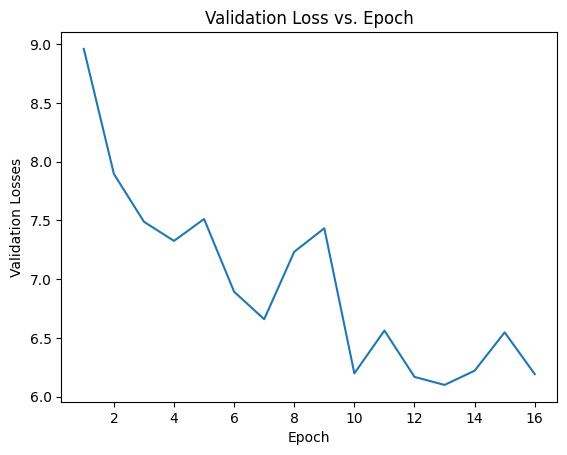

In [ ]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

## Generate Result

In [ ]:
# Convert data to numpy arrays
unknown_test = unknown_data.to_numpy()

# Time series transformation
unknown_test = unknown_test.reshape(unknown_test.shape[0], 1, unknown_test.shape[1])

# Get result (need to choose a model)
y_unknown = rnn_model.predict(unknown_test)

860/860 [==============================] - 2s 2ms/step


In [ ]:
# Append result to the dataframe
pd.DataFrame(y_unknown)
data_copy = data_copy[data_copy.isna().any(axis=1)]
data_copy = data_copy.loc[:, ['Time', 'BS']]
data_copy['Energy'] = y_unknown
data_copy

,Time,BS,Energy
14550,2023-01-01 01:00:00,B_105,47.316608
45456,2023-01-01 01:00:00,B_328,18.881041
7212,2023-01-01 01:00:00,B_52,16.949362
35266,2023-01-01 01:00:00,B_255,17.766401
52652,2023-01-01 01:00:00,B_380,17.566393
...,...,...,...
90481,2023-01-08 00:00:00,B_650,27.508802
90055,2023-01-08 00:00:00,B_647,12.840732
108546,2023-01-08 00:00:00,B_781,49.553059
89913,2023-01-08 00:00:00,B_646,12.967471


In [ ]:
# Merge result above to power prediction
power_pred['Time'] = pd.to_datetime(power_pred['Time'])
power_pred.drop(columns=['Energy'], inplace=True)
power_pred = power_pred.merge(data_copy, on=["Time", "BS"], how="left")
power_pred

# Create a new DataFrame with switched columns
df_switched = df[['Time', 'BS', 'Energy', 'w']]

# Reset the index
df_switched.reset_index(drop=True, inplace=True)

# Change datetime to string
df_switched['Time'] = df_switched['Time'].astype('str')

# Merge time and BS with a "_" to meet the submission requirement
df_switched['Time'] = df_switched['Time'] + '_' + df_switched['BS']
df_switched = df_switched.drop(columns=["BS"])
df_switched

,Time,Energy,w
0,2023-01-01 06:00:00_B_0,32.008049,1
1,2023-01-01 11:00:00_B_0,60.390934,1
2,2023-01-01 12:00:00_B_0,58.007496,1
3,2023-01-01 13:00:00_B_0,59.624378,1
4,2023-01-01 23:00:00_B_0,57.812489,1
...,...,...,...
26134,2023-01-02 19:00:00_B_1019,16.930706,5
26135,2023-01-02 20:00:00_B_1019,17.309809,5
26136,2023-01-02 21:00:00_B_1019,17.809099,5
26137,2023-01-02 22:00:00_B_1019,18.190105,5


In [ ]:
# Generate result to submit
df_switched.to_csv('result_GitData.csv', index=False)